## 라이브러리 임포트

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install catboost
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

## Loading data

In [2]:
# raw data 로딩 
raw_data = pd.read_csv(r'C:\\Users\\user\\Desktop\\intern.csv')
raw_data.head()

,Unnamed: 0,ORD_NO,H_YMD,O_YMD,PKG_GOODS_NO,PKG_GOODS_NM,GOODS_NO,GOODS_NM,STD_GSGR_NO_LEV1_NM,ORD_QTY,CANCEL_QTY,RET_QTY,REAL_ORD_QTY,RECVR_ROAD_BASE_ADDR,SALE_PRICE,DISCOUNT_AMT,FINAL_PRICE
0,0,202201095519105,2022-01-11 00:00:00,2022-01-09 12:26:10,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,충청북도 증평군 증평읍 송산로 11 (지평더웰아파트),6900,569.00,6331
1,1,202201105522898,2022-01-11 00:00:00,2022-01-10 10:35:49,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,서울특별시 강남구 논현로85길 52 (역삼동),6900,177.00,6723
2,2,202201115527172,2022-01-12 00:00:00,2022-01-11 11:38:32,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"서울특별시 송파구 올림픽로4길 42 (잠실동, 우성아파트)",6900,221.00,6679
3,3,202201105523467,2022-01-12 00:00:00,2022-01-10 13:21:51,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,강원도 속초시 도리원길 11-14 (노학동),6900,128.00,6772
4,4,202201105522519,2022-01-11 00:00:00,2022-01-10 08:16:21,단품,단품,1901012353,수제계란말이(350g),반찬,1,0,0,1,"경기도 용인시 수지구 동천로 64 (동천동, 동천마을동문굿모닝힐5차아파트)",6900,157.00,6743


In [3]:
weather = pd.read_excel(r'C:\Users\user\Desktop\w.xlsx')
weather.rename(columns={'date':'H_YMD'}, inplace=True)
weather['H_YMD'] = pd.to_datetime(weather['H_YMD'])
weather = weather.sort_values(by = 'H_YMD')
weather.drop('spot', axis=1, inplace=True)

weather

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\user\\Desktop\\w.xlsx'

In [1036]:
# 불필요한 컬럼들 제거
# Unnamed: 단순 데이터 순서를 나타내는 컬럼이기에 삭제
# O_YMD: 주문 시간은 오더 건수와 큰 상관이 없기에 삭제
# ORD_NO: 주문 내용의 일련번호이기에 삭제
# PKG_GOODS_NO: PKG_GOODS_NM과 내용이 겹치고 잘못 적재된 데이터이기에 삭제
# RECVR_ROAD_BASE_ADDR: 비대면으로 주문하는 시대에 지역정보는 큰 의미가 없을 것 같아 삭제
# 등등 미래에 예측할 수 없는 데이터는 모두 삭제

# 카피 데이터 생성
copy_data = raw_data[['H_YMD', 'GOODS_NO', 'ORD_QTY', 'REAL_ORD_QTY', 'SALE_PRICE']]

# 희망배송일 순서대로 데이터를 정렬
copy_data = copy_data.sort_values(by = 'H_YMD')


copy_data.head()

,H_YMD,GOODS_NO,ORD_QTY,REAL_ORD_QTY,SALE_PRICE
166288,2020-01-01 00:00:00,14375,1,1,8600
37753,2020-01-01 00:00:00,1901012353,2,2,6300
162585,2020-01-01 00:00:00,1823,1,1,3300
164041,2020-01-01 00:00:00,1712010310,1,1,6900
164040,2020-01-01 00:00:00,1712010310,1,1,6900


## raw data 확인

In [640]:
print('Train rows: ', copy_data.shape[0])      # 데이터 행 개수
print('Train columns: ', copy_data.shape[1])   # 데이터 열 개수

Train rows:  724702
Train columns:  5


In [641]:
copy_data.head().T

,166288,37753,162585,164041,164040
H_YMD,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00,2020-01-01 00:00:00
GOODS_NO,14375,1901012353,1823,1712010310,1712010310
ORD_QTY,1,2,1,1,1
REAL_ORD_QTY,1,2,1,1,1
SALE_PRICE,8600,6300,3300,6900,6900


In [642]:
copy_data.describe()

,GOODS_NO,ORD_QTY,REAL_ORD_QTY,SALE_PRICE
count,724702.00,724702.00,724702.00,724702.00
mean,1042033183.53,1.12,1.07,7262.44
std,913607986.64,0.47,0.50,2417.24
min,1823.00,1.00,0.00,2600.00
25%,14375.00,1.00,1.00,4900.00
50%,1712010310.00,1.00,1.00,7000.00
75%,1808011751.00,1.00,1.00,8800.00
max,2204016772.00,45.00,45.00,35600.00


In [643]:
# 데이터의 처음 시작 날짜와 마지막 날짜 확인

copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])
print('Min H_YMD from train set: %s' % copy_data['H_YMD'].min().date())
print('Max H_YMD from train set: %s' % copy_data['H_YMD'].max().date())

Min H_YMD from train set: 2020-01-01
Max H_YMD from train set: 2022-05-31


## Data cleaning

In [1037]:
# 이상치 제거

def outlier(df,col):
    q1 = df[col].quantile(0.25) # 1사분위
    q3 = df[col].quantile(0.75) # 3사분위 
    iqr = q3 - q1               # iqr 수치

    df.loc[(df[col] > (q3 + 1.5 * iqr)) | (df[col] < (q1 - 1.5 * iqr)), col] = df[col].median() # 이상치를 중앙값으로 대체

ol_col = ['ORD_QTY', 'REAL_ORD_QTY', 'SALE_PRICE']

for i in ol_col:
    outlier(copy_data, i)

### Data processing

In [793]:
copy_data

,H_YMD,GOODS_NO,ORD_QTY,REAL_ORD_QTY,SALE_PRICE
166288,2020-01-01 00:00:00,14375,1,1,8600
37753,2020-01-01 00:00:00,1901012353,1,1,6300
162585,2020-01-01 00:00:00,1823,1,1,3300
164041,2020-01-01 00:00:00,1712010310,1,1,6900
164040,2020-01-01 00:00:00,1712010310,1,1,6900
...,...,...,...,...,...
236658,2022-05-31 00:00:00,1803010879,1,1,4500
241774,2022-05-31 00:00:00,1909013359,1,1,9900
236656,2022-05-31 00:00:00,1803010879,1,1,4500
241810,2022-05-31 00:00:00,1909013359,1,1,9900


In [1071]:
# 데이터를 H_YMD(희망배송일), GOODS_NO(상품 번호)로 groupby를 해준다.
# SALE_PRICE(판매가격), ORD_QTY(주문 건수), REAL_ORD_QTY(최종주문건수)의 평균값과 매매거래량 변수를 만든다.

copy_data = copy_data.groupby(['H_YMD', 'GOODS_NO'], as_index=False)
copy_data = copy_data.agg({
                           'SALE_PRICE':['sum', 'mean'], 
                           'ORD_QTY':['sum', 'mean', 'count'], 
                           'REAL_ORD_QTY':['sum', 'mean','count'], 
                        })
                        
# 변수들의 이름을 재정의 해준다.
copy_data.columns = [
                     'H_YMD', 'GOODS_NO',
                     'SALE_PRICE', 'mean_sale_price',
                     'ORD_QTY', 'mean_ord_qty',  'ord_transactions', 
                     'REAL_ORD_QTY', 'mean_real_ord_qty', 'real_transactions',
                     ]
                     

In [1072]:
# REAL_ORD_QTY 변수는 예측 불가 변수이기 때문에 해당 변수에서 파생된 변수들을 삭제한다

copy_data.drop(['mean_real_ord_qty', 'real_transactions'], axis=1, inplace=True)

copy_data

,H_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY
0,2020-01-01,1823,82500,82500.00,25,25.00,1,25
1,2020-01-01,3273,92400,92400.00,22,22.00,1,22
2,2020-01-01,4092,36000,36000.00,9,9.00,1,9
3,2020-01-01,13957,88200,88200.00,18,18.00,1,18
4,2020-01-01,14375,722400,722400.00,84,84.00,1,84
...,...,...,...,...,...,...,...,...
10925,2022-05-31,2010014667,143000,143000.00,22,22.00,1,22
10926,2022-05-31,2010014707,297600,297600.00,31,31.00,1,31
10927,2022-05-31,2012014895,715500,715500.00,53,53.00,1,53
10928,2022-05-31,2103015231,386100,386100.00,39,39.00,1,39


In [1073]:
# 희망배송일의 연도,월,일 데이터를 각각 year, month, day 변수에 넣어준다.

copy_data['H_YMD'] = pd.to_datetime(copy_data['H_YMD'])
copy_data['year'] = copy_data['H_YMD'].dt.year
copy_data['month'] = copy_data['H_YMD'].dt.month
copy_data['day'] = copy_data['H_YMD'].dt.day

## 단변량 분석

In [1074]:
# 월별 최종 주문량
gp_month_mean = copy_data.groupby(['month'], as_index=False)['REAL_ORD_QTY'].mean()
gp_month_sum = copy_data.groupby(['month'], as_index=False)['REAL_ORD_QTY'].sum()

# 상품별 최종 주문량
gp_category_mean = copy_data.groupby(['GOODS_NO'], as_index=False)['REAL_ORD_QTY'].mean()
gp_category_sum = copy_data.groupby(['GOODS_NO'], as_index=False)['REAL_ORD_QTY'].sum()

### 월별 최종 주문량 그래프

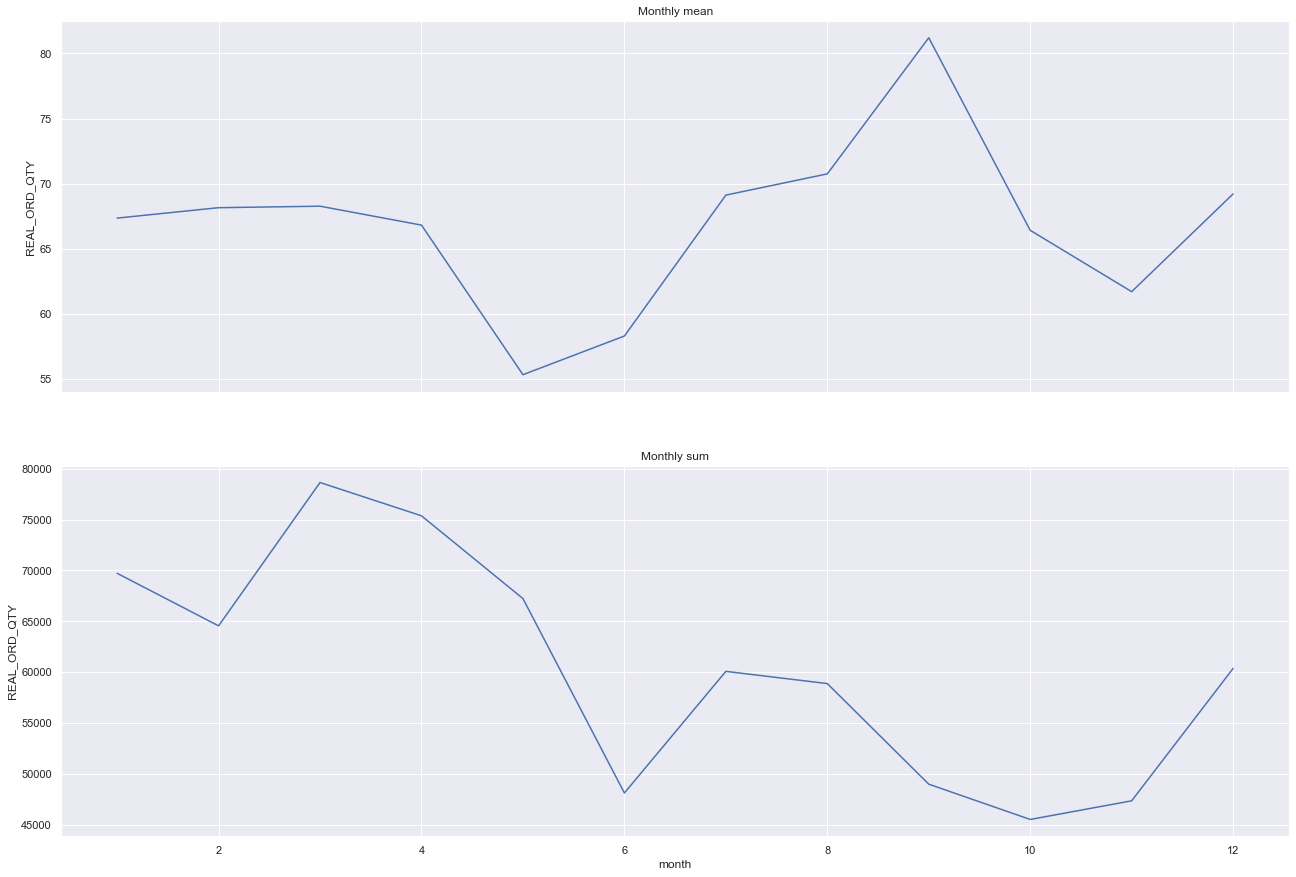

In [1075]:
f, axes = plt.subplots(2, 1, figsize=(22, 15), sharex=True)
sns.lineplot(x="month", y="REAL_ORD_QTY", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="REAL_ORD_QTY", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

### 상품별 최종 주문량 그래프

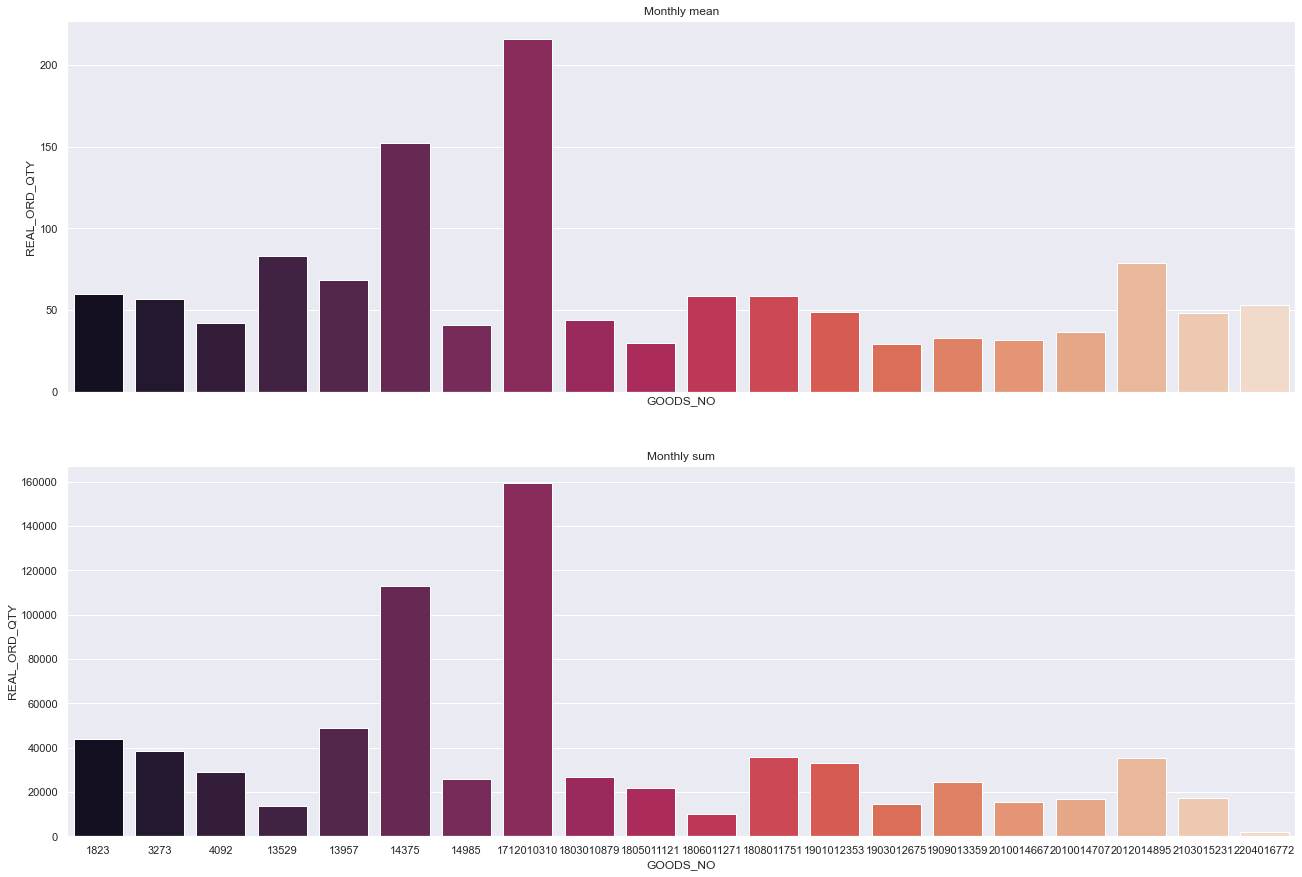

In [1076]:
f, axes = plt.subplots(2, 1, figsize=(22, 15), sharex=True)
sns.barplot(x="GOODS_NO", y="REAL_ORD_QTY", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="GOODS_NO", y="REAL_ORD_QTY", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

### 최종 주문량 분석

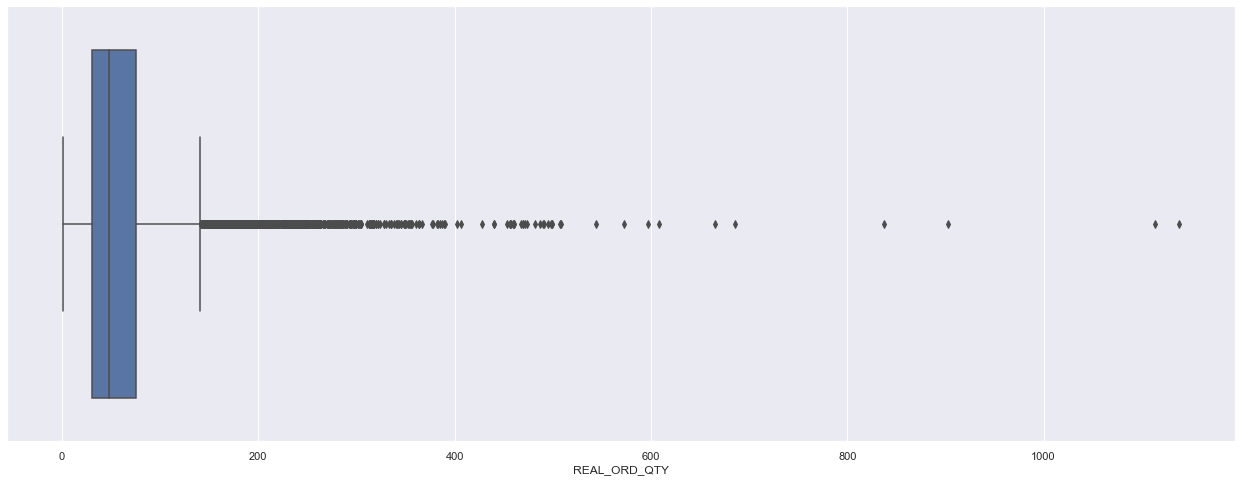

In [1077]:
plt.subplots(figsize=(22, 8))
sns.boxplot(copy_data['REAL_ORD_QTY'])
plt.show()

## 라벨 생성

In [1042]:
copy_data.isna().sum()

H_YMD               0
GOODS_NO            0
SALE_PRICE          0
mean_sale_price     0
ORD_QTY             0
mean_ord_qty        0
ord_transactions    0
REAL_ORD_QTY        0
year                0
month               0
day                 0
dtype: int64

In [1113]:
# 일별 판매량 데이터를 생성한다
# shift() 메서드를 통해 내일 판매량을 땡겨온다

# 한달 데이터 예측
copy_data['item_cnt_day'] = copy_data.sort_values('H_YMD').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(-26)

# 일주일 데이터 예측
# copy_data['item_cnt_day'] = copy_data.sort_values('H_YMD').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(-6)

In [1114]:
shift_data = copy_data.copy()

shift_data.head()

,H_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,year,month,day,item_cnt_day
0,2020-01-01,1823,82500,82500.00,25,25.00,1,25,2020,1,1,64.00
1,2020-01-01,3273,92400,92400.00,22,22.00,1,22,2020,1,1,76.00
2,2020-01-01,4092,36000,36000.00,9,9.00,1,9,2020,1,1,39.00
3,2020-01-01,13957,88200,88200.00,18,18.00,1,18,2020,1,1,95.00
4,2020-01-01,14375,722400,722400.00,84,84.00,1,84,2020,1,1,100.00


## 피쳐 엔지니어링

In [1115]:
# 판매가격 구성단위 변수 생성
# 판매가격을 최종 주문건수르 나눈 item_price_unit 변수를 생성한다.

shift_data['item_price_unit'] = shift_data['SALE_PRICE'] // shift_data['REAL_ORD_QTY']
shift_data['item_price_unit'].fillna(0, inplace=True)

In [1116]:
# 각 제품의 최솟값과 최댓값을 변수로 넣어준다.(가격별 상승, 하강 추이를 파악하기 위해)

gp_item_price = shift_data.sort_values('H_YMD').groupby(['GOODS_NO'], as_index=False).agg({'SALE_PRICE':[np.min, np.max]})
gp_item_price.columns = ['GOODS_NO', 'hist_min_item_price', 'hist_max_item_price']

shift_data = pd.merge(shift_data, gp_item_price, on='GOODS_NO', how='left')

In [1117]:
# 판매액에서 최솟값을 빼 상승값으로 넣어주고
# 판매액에서 최댓값을 빼 하강값으로 넣어준다.

shift_data['price_increase'] = shift_data['SALE_PRICE'] - shift_data['hist_min_item_price']
shift_data['price_decrease'] = shift_data['hist_max_item_price'] - shift_data['SALE_PRICE']

In [1118]:
fe_data = shift_data.copy()

fe_data.head()

,H_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,year,month,day,item_cnt_day,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,2020-01-01,1823,82500,82500.00,25,25.00,1,25,2020,1,1,64.00,3300,49500,1171500,33000,1089000
1,2020-01-01,3273,92400,92400.00,22,22.00,1,22,2020,1,1,76.00,4200,4200,613200,88200,520800
2,2020-01-01,4092,36000,36000.00,9,9.00,1,9,2020,1,1,39.00,4000,4000,484000,32000,448000
3,2020-01-01,13957,88200,88200.00,18,18.00,1,18,2020,1,1,95.00,4900,4900,710500,83300,622300
4,2020-01-01,14375,722400,722400.00,84,84.00,1,84,2020,1,1,100.00,8600,8800,9786800,713600,9064400


## rolling

In [1119]:
# 몇개의 데이터를 가지고 연산을 할 것인가
# 데이터들을 순차적으로 3달 (window=3)씩 선택해서 mean처럼 이동평균을 냄
# 3일치의 min,max,std도 고려할 수 있습니다. 

# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    fe_data[('ORD_QTY_%s' % function_name[i])] = fe_data.sort_values('H_YMD').groupby(['GOODS_NO'])['ORD_QTY'].apply(function_list[i])


In [1120]:
# Fill the empty std features with 0
fe_data['ORD_QTY_std'].fillna(0, inplace=True)

In [1121]:
rolling_data = fe_data.copy()

rolling_data.head()

,H_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,year,month,...,item_cnt_day,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,ORD_QTY_min,ORD_QTY_max,ORD_QTY_mean,ORD_QTY_std
0,2020-01-01,1823,82500,82500.00,25,25.00,1,25,2020,1,...,64.00,3300,49500,1171500,33000,1089000,25.00,25.00,25.00,0.00
1,2020-01-01,3273,92400,92400.00,22,22.00,1,22,2020,1,...,76.00,4200,4200,613200,88200,520800,22.00,22.00,22.00,0.00
2,2020-01-01,4092,36000,36000.00,9,9.00,1,9,2020,1,...,39.00,4000,4000,484000,32000,448000,9.00,9.00,9.00,0.00
3,2020-01-01,13957,88200,88200.00,18,18.00,1,18,2020,1,...,95.00,4900,4900,710500,83300,622300,18.00,18.00,18.00,0.00
4,2020-01-01,14375,722400,722400.00,84,84.00,1,84,2020,1,...,100.00,8600,8800,9786800,713600,9064400,84.00,84.00,84.00,0.00


## lag

In [1122]:
# 시점을 1일, 2일, 3일로 미뤄서 lag 변수를 생성해준다.

lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('ORD_QTY_shifted%s' % lag)
    #train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['GOODS_NO'])['REAL_ORD_QTY'].shift(lag)
    rolling_data[ft_name] = rolling_data.sort_values('H_YMD').groupby(['GOODS_NO'])['ORD_QTY'].shift(lag)
    # Fill the empty shifted features with 0
    rolling_data[ft_name].fillna(0, inplace=True)

In [1123]:
lag_data = rolling_data.copy()

lag_data.head()

,H_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,year,month,...,hist_max_item_price,price_increase,price_decrease,ORD_QTY_min,ORD_QTY_max,ORD_QTY_mean,ORD_QTY_std,ORD_QTY_shifted1,ORD_QTY_shifted2,ORD_QTY_shifted3
0,2020-01-01,1823,82500,82500.00,25,25.00,1,25,2020,1,...,1171500,33000,1089000,25.00,25.00,25.00,0.00,0.00,0.00,0.00
1,2020-01-01,3273,92400,92400.00,22,22.00,1,22,2020,1,...,613200,88200,520800,22.00,22.00,22.00,0.00,0.00,0.00,0.00
2,2020-01-01,4092,36000,36000.00,9,9.00,1,9,2020,1,...,484000,32000,448000,9.00,9.00,9.00,0.00,0.00,0.00,0.00
3,2020-01-01,13957,88200,88200.00,18,18.00,1,18,2020,1,...,710500,83300,622300,18.00,18.00,18.00,0.00,0.00,0.00,0.00
4,2020-01-01,14375,722400,722400.00,84,84.00,1,84,2020,1,...,9786800,713600,9064400,84.00,84.00,84.00,0.00,0.00,0.00,0.00


## trend 반영

In [1124]:
# lag 시켰을 때 나온 item_count 판매량을 lag로 나눠서 1을 더해준다.

lag_data['item_trend'] = lag_data['ORD_QTY']

for lag in lag_list:
    ft_name = ('ORD_QTY_shifted%s' % lag)
    lag_data['item_trend'] -= lag_data[ft_name]

lag_data['item_trend'] /= len(lag_list) + 1

In [1091]:
lag_data.describe().T

,count,mean,std,min,25%,50%,75%,max
GOODS_NO,10930.00,1132619071.25,927668069.78,1823.00,13957.00,1803010879.00,1903012675.00,2204016772.00
SALE_PRICE,10930.00,481483.42,524067.29,4000.00,182400.00,285600.00,542218.50,9786800.00
mean_sale_price,10930.00,481483.42,524067.29,4000.00,182400.00,285600.00,542218.50,9786800.00
ORD_QTY,10930.00,66.30,62.74,1.00,31.00,48.00,75.00,1138.00
mean_ord_qty,10930.00,66.30,62.74,1.00,31.00,48.00,75.00,1138.00
ord_transactions,10930.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
REAL_ORD_QTY,10930.00,66.30,62.74,1.00,31.00,48.00,75.00,1138.00
year,10930.00,2020.85,0.72,2020.00,2020.00,2021.00,2021.00,2022.00
month,10930.00,6.02,3.43,1.00,3.00,5.00,9.00,12.00
day,10930.00,15.76,8.78,1.00,8.00,16.00,23.00,31.00


In [1125]:
final_data = lag_data.copy()

final_data.head()

,H_YMD,GOODS_NO,SALE_PRICE,mean_sale_price,ORD_QTY,mean_ord_qty,ord_transactions,REAL_ORD_QTY,year,month,...,price_increase,price_decrease,ORD_QTY_min,ORD_QTY_max,ORD_QTY_mean,ORD_QTY_std,ORD_QTY_shifted1,ORD_QTY_shifted2,ORD_QTY_shifted3,item_trend
0,2020-01-01,1823,82500,82500.00,25,25.00,1,25,2020,1,...,33000,1089000,25.00,25.00,25.00,0.00,0.00,0.00,0.00,6.25
1,2020-01-01,3273,92400,92400.00,22,22.00,1,22,2020,1,...,88200,520800,22.00,22.00,22.00,0.00,0.00,0.00,0.00,5.50
2,2020-01-01,4092,36000,36000.00,9,9.00,1,9,2020,1,...,32000,448000,9.00,9.00,9.00,0.00,0.00,0.00,0.00,2.25
3,2020-01-01,13957,88200,88200.00,18,18.00,1,18,2020,1,...,83300,622300,18.00,18.00,18.00,0.00,0.00,0.00,0.00,4.50
4,2020-01-01,14375,722400,722400.00,84,84.00,1,84,2020,1,...,713600,9064400,84.00,84.00,84.00,0.00,0.00,0.00,0.00,21.00


## 데이터 분할

In [1126]:
H_YMD = final_data['H_YMD'] # 추후 반영될 날짜 데이터
G_N = final_data['GOODS_NO'] # 추후 반영될 상품번호 데이터

final_data.set_index('H_YMD', inplace=True)

In [1127]:
test_set = final_data[(final_data.year == 2022) & (final_data.month == 5)] # 2022년 5월 데이터를 테스트셋으로 설정

idx = final_data[(final_data.year == 2022) & (final_data.month == 5)].index # 2022년 5월 데이터의 인덱스 저장
final_data.drop(idx, inplace=True)                                          # 2022년 5월 데이터 삭제  

train_set = final_data[:7307]            # 남은 데이터의 70%를 학습데이터로 설정         
validation_set = final_data[7307:]       # 남은 데이터의 30%를 학습 데이터로 설정

train_set.dropna(subset=['REAL_ORD_QTY'], inplace=True)  # train 셋에서 일별 판매 데이터 제거
validation_set.dropna(subset=['REAL_ORD_QTY'], inplace=True) # val 셋에서 일별 판매 데이터 제거

train_set.dropna(inplace=True) 
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Train set records: 7281
Validation set records: 3129
Test set records: 492
Train set records: 7281 (2% of complete data)
Validation set records: 3129 (1% of complete data)


In [1128]:
# 학습데이터의 상품번호 별 일별 판매량 평균
gp_goods_mean_t = train_set.groupby(['GOODS_NO']).agg({'item_cnt_day': ['mean']})
gp_goods_mean_t.columns = ['GOODS_mean']
gp_goods_mean_t.reset_index(inplace=True)
# 검증데이터의 상품번호 별 일별 판매량 평균
gp_goods_mean_v = validation_set.groupby(['GOODS_NO']).agg({'item_cnt_day': ['mean']})
gp_goods_mean_v.columns = ['GOODS_mean']
gp_goods_mean_v.reset_index(inplace=True)

# 핛습데이터의 연도별 일별 판매량 평균
gp_year_mean_t = train_set.groupby(['year']).agg({'item_cnt_day': ['mean']})
gp_year_mean_t.columns = ['year_mean']
gp_year_mean_t.reset_index(inplace=True)
# 검증데이터의 연도별 일별 판매량 평균
gp_year_mean_v = validation_set.groupby(['year']).agg({'item_cnt_day': ['mean']})
gp_year_mean_v.columns = ['year_mean']
gp_year_mean_v.reset_index(inplace=True)

# 학습데이터의 월별 일별 판매량 평균
gp_month_mean_t = train_set.groupby(['month']).agg({'item_cnt_day': ['mean']})
gp_month_mean_t.columns = ['month_mean']
gp_month_mean_t.reset_index(inplace=True)
# 검증데이터의 월별 일별 판매량 평균
gp_month_mean_v = validation_set.groupby(['month']).agg({'item_cnt_day': ['mean']})
gp_month_mean_v.columns = ['month_mean']
gp_month_mean_v.reset_index(inplace=True)

# 훈련 데이터에 판매량 평균 데이터들 결함
train_set = pd.merge(train_set, gp_goods_mean_t, on=['GOODS_NO'], how='left')
train_set = pd.merge(train_set, gp_year_mean_t, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean_t, on=['month'], how='left')

# 검증 데이터에 판매량 평균 데이터들 결함
validation_set = pd.merge(validation_set, gp_goods_mean_v, on=['GOODS_NO'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean_v, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean_v, on=['month'], how='left')

In [1129]:
# 훈련데이터에서 일별 판매량과 월 단위 데이터를 제거 
# 타겟에 제거한 일별 데이터를 삽입

X_train = train_set.drop(['REAL_ORD_QTY'], axis=1)
y_train = train_set['REAL_ORD_QTY'].astype(int)

# 검증데이터에서 일별 판매량과 월 단위 데이터를 제거 
# 타겟에 제거한 일별 데이터를 삽입

X_val = validation_set.drop(['REAL_ORD_QTY'], axis=1)
y_val = validation_set['REAL_ORD_QTY'].astype(int)

In [1130]:
# Integer features (used by catboost model).
int_features = ['GOODS_NO', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_val[int_features] = X_val[int_features].astype('int32')

In [1131]:
# 상품별 일별 판매량 평균
gp_shop_mean = test_set.groupby(['GOODS_NO']).agg({'item_cnt_day': ['mean']})
gp_shop_mean.columns = ['GOODS_mean']
gp_shop_mean.reset_index(inplace=True)

# 연도별 일별 판매량 평균
gp_year_mean = test_set.groupby(['year']).agg({'item_cnt_day': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# 월별 일별 판매량 평균
gp_month_mean = test_set.groupby(['month']).agg({'item_cnt_day': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# 테스트 셋에도 해당 데이터들을 삽입
test_set = pd.merge(test_set, gp_shop_mean, on=['GOODS_NO'], how='left')
test_set = pd.merge(test_set, gp_year_mean, on=['year'], how='left')
test_set = pd.merge(test_set, gp_month_mean, on=['month'], how='left')

In [826]:
train_set.columns

Index(['GOODS_NO', 'SALE_PRICE', 'mean_sale_price', 'ORD_QTY', 'mean_ord_qty',
       'ord_transactions', 'REAL_ORD_QTY', 'year', 'month', 'day',
       'item_cnt_day', 'item_price_unit', 'hist_min_item_price',
       'hist_max_item_price', 'price_increase', 'price_decrease',
       'ORD_QTY_min', 'ORD_QTY_max', 'ORD_QTY_mean', 'ORD_QTY_std',
       'ORD_QTY_shifted1', 'ORD_QTY_shifted2', 'ORD_QTY_shifted3',
       'item_trend', 'GOODS_mean_x', 'year_mean_x', 'month_mean_x',
       'GOODS_mean_y', 'year_mean_y', 'month_mean_y'],
      dtype='object')

In [1132]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['GOODS_NO'], keep='last')
X_test = test_set

y_test = test_set['REAL_ORD_QTY']    # 타겟 데이터에 일별 판매량 삽입
X_test.drop('REAL_ORD_QTY', axis=1, inplace=True)  # 테스트 데이터에서 일별 판매량 제거

X_test = X_test[X_train.columns]

In [1133]:
sets = [X_train, X_val, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for goods_no in dataset['GOODS_NO'].unique():
        for column in dataset.columns:
            goods_median = dataset[(dataset['GOODS_NO'] == goods_no)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['GOODS_NO'] == goods_no), column] = goods_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [1134]:
X_test.head().T

,0,1,2,3,4
GOODS_NO,1823.00,3273.00,4092.00,13957.00,14375.00
SALE_PRICE,207900.00,390100.00,220000.00,431200.00,1108800.00
mean_sale_price,207900.00,390100.00,220000.00,431200.00,1108800.00
ORD_QTY,63.00,93.00,55.00,88.00,126.00
mean_ord_qty,63.00,93.00,55.00,88.00,126.00
ord_transactions,1.00,1.00,1.00,1.00,1.00
year,2022.00,2022.00,2022.00,2022.00,2022.00
month,5.00,5.00,5.00,5.00,5.00
day,2.00,2.00,2.00,2.00,2.00
item_cnt_day,NaN,NaN,NaN,NaN,NaN


In [728]:
X_train.columns

Index(['GOODS_NO', 'SALE_PRICE', 'mean_sale_price', 'ORD_QTY', 'mean_ord_qty',
       'ord_transactions', 'year', 'month', 'day', 'item_cnt_day',
       'item_price_unit', 'hist_min_item_price', 'hist_max_item_price',
       'ORD_QTY_min', 'ORD_QTY_max', 'ORD_QTY_mean', 'ORD_QTY_std',
       'ORD_QTY_shifted1', 'ORD_QTY_shifted2', 'ORD_QTY_shifted3',
       'item_trend', 'GOODS_mean', 'year_mean', 'month_mean'],
      dtype='object')

In [1135]:
# Use only part of features on XGBoost.
# xgb_features = ['REAL_ORD_QTY','REAL_ORD_QTY_mean', 'REAL_ORD_QTY_std', 
#                 'REAL_ORD_QTY_shifted1', 'REAL_ORD_QTY_shifted2', 'REAL_ORD_QTY_shifted3', 
#                 'GOODS_mean','item_trend', 'mean_real_ord_qty']

xgb_features = ['ORD_QTY','ORD_QTY_mean', 'ORD_QTY_std', 
                'ORD_QTY_shifted1', 'ORD_QTY_shifted2', 'ORD_QTY_shifted3', 
                'GOODS_mean','item_trend']

xgb_train = X_train[xgb_features]
xgb_val = X_val[xgb_features]
xgb_test = X_test[xgb_features]

In [1136]:
xgb_model = XGBRegressor(max_depth=5, 
                         n_estimators=1000, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, y_train), (xgb_val, y_val)], 
              verbose=20, 
              early_stopping_rounds=30)

[0]	validation_0-rmse:71.45746	validation_1-rmse:65.49653
[20]	validation_0-rmse:36.27482	validation_1-rmse:33.58660
[40]	validation_0-rmse:35.90612	validation_1-rmse:33.37583
[60]	validation_0-rmse:35.66105	validation_1-rmse:33.09302
[80]	validation_0-rmse:35.45179	validation_1-rmse:32.93920
[100]	validation_0-rmse:35.30291	validation_1-rmse:32.66534
[120]	validation_0-rmse:35.17262	validation_1-rmse:32.49017
[140]	validation_0-rmse:35.01347	validation_1-rmse:32.48175
[160]	validation_0-rmse:34.88821	validation_1-rmse:32.39956
[180]	validation_0-rmse:34.77503	validation_1-rmse:32.41269
[184]	validation_0-rmse:34.74657	validation_1-rmse:32.47692


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1000,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

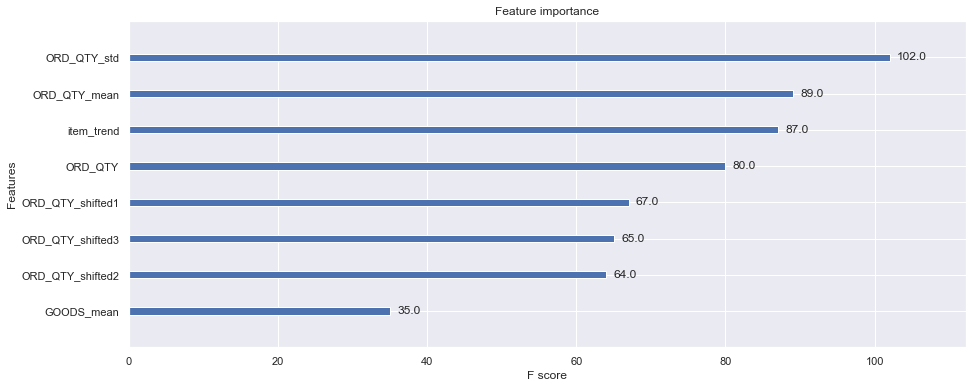

In [1137]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [1138]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [1139]:
from sklearn.metrics import r2_score

print('r2:', r2_score(y_test, xgb_test_pred))
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, xgb_val_pred)))

r2: 0.7898326128014951
Train rmse: 34.9301453818558
Validation rmse: 32.299461000947765


In [1140]:
# 자재코드와 자재명을 딕셔너리 형태로 만들기
GOODS_DIC = {171201310 : '두메산나물비빔밥재료', 14375:	'옛날잡채(500g)', 3273:'채소계란찜(340g)', 13957:'셀프두부조림(600g)', 1901012353:'수제계란말이(350g)',
             13529:'메밀소바(2인분)', 1803010879:'고소한도토리묵무침(360g)', 2012014895:'한돈 제육볶음(700g)', 2204016772:'소고기유니짜장소스(1인분, 200g)', 
             1823:'숙주나물(300g)', 4092:'건표고버섯볶음', '14985':'양장피', 1808011751:'꼬막무침 (260g)', 1903012675:'순살코다리강정(180g)', 
             2010014667:'우삼겹숙주볶음(250g)', 1806011271:'열무비빔밥재료믹스(2인분)', 2103015231:'[심방골주부X더반찬] 시골 돼지짜글이(600g)', 
             2010014707:'고구마 품은 라자냐(450g)', 1805011121:'고사리나물볶음(150g)', 1909013359:'가정집 오징어불고기/셀프(380g)'
             }

In [1141]:
H_YMD = pd.DataFrame(H_YMD)

test_h_ymd = H_YMD[-492:]
test_h_ymd.reset_index(drop=True, inplace=True)

In [1142]:
show_y_test = pd.DataFrame(y_test)
show_y_test['GOODS_NO'] = X_test.GOODS_NO
show_y_test['H_YMD'] = test_h_ymd
show_y_test.set_index('H_YMD', inplace=True)

for n in GOODS_DIC.keys():
    show_y_test['GOODS_NO'].loc[show_y_test['GOODS_NO'] == n ] = GOODS_DIC[n]
    
show_y_test

,REAL_ORD_QTY,GOODS_NO
H_YMD,,
2022-05-02,63,숙주나물(300g)
2022-05-02,93,채소계란찜(340g)
2022-05-02,55,건표고버섯볶음
2022-05-02,88,셀프두부조림(600g)
2022-05-02,126,옛날잡채(500g)
...,...,...
2022-05-31,22,우삼겹숙주볶음(250g)
2022-05-31,31,고구마 품은 라자냐(450g)
2022-05-31,53,한돈 제육볶음(700g)


In [1143]:
xgb_test_pred = pd.DataFrame(xgb_test_pred)
xgb_test_pred['GOODS_NO'] = X_test.GOODS_NO
xgb_test_pred['H_YMD'] = test_h_ymd
xgb_test_pred.columns = ['item_cnt_day', 'GOODS_NO', 'H_YMD']
xgb_test_pred.set_index('H_YMD', inplace=True)

for n in GOODS_DIC.keys():
    xgb_test_pred['GOODS_NO'].loc[xgb_test_pred['GOODS_NO'] == n ] = GOODS_DIC[n]

xgb_test_pred

,item_cnt_day,GOODS_NO
H_YMD,,
2022-05-02,61.36,숙주나물(300g)
2022-05-02,125.53,채소계란찜(340g)
2022-05-02,57.22,건표고버섯볶음
2022-05-02,88.87,셀프두부조림(600g)
2022-05-02,170.98,옛날잡채(500g)
...,...,...
2022-05-31,23.52,우삼겹숙주볶음(250g)
2022-05-31,29.18,고구마 품은 라자냐(450g)
2022-05-31,54.40,한돈 제육볶음(700g)


In [1111]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [1144]:
def evaluate_regr(y, pred):
    mse = mean_squared_error(y, pred)
    rmse_val = np.sqrt(mse)
    mae_val = mean_absolute_error(y, pred)
    r2 = r2_score(y, pred)
    print('RMSE : {} | MAE : {} | r2 : {} '.format(round(rmse_val,5),round(mae_val,5),round(r2,5)))

# 여러 모델의 성능 확인 함수 
def get_model_predict(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
#--------------------------------------------------------------------
#모델별로 평가 확인 

ridge_reg = Ridge(alpha=0)      # best alpha = 0
lasso_reg = Lasso(alpha=1)        # best alpha = 1
tree_reg = DecisionTreeRegressor(random_state=13)
forest_reg = RandomForestRegressor(n_estimators=100,random_state=13)

for model in [ridge_reg, lasso_reg,tree_reg,forest_reg]:
# for model in [forest_reg]:
    get_model_predict(model, X_train, X_val, y_train, y_val)

### Ridge ###
RMSE : 0.0 | MAE : 0.0 | r2 : 1.0 
### Lasso ###
RMSE : 0.10738 | MAE : 0.07284 | r2 : 1.0 
### DecisionTreeRegressor ###
RMSE : 6.57289 | MAE : 0.20454 | r2 : 0.9882 
### RandomForestRegressor ###
RMSE : 3.87658 | MAE : 0.12489 | r2 : 0.99589 


In [876]:
X_test.columns

Index(['GOODS_NO', 'SALE_PRICE', 'mean_sale_price', 'ORD_QTY', 'mean_ord_qty',
       'ord_transactions', 'mean_real_ord_qty', 'real_transactions', 'year',
       'month', 'day', 'item_cnt_day', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'ORD_QTY_min', 'ORD_QTY_max', 'ORD_QTY_mean',
       'ORD_QTY_std', 'ORD_QTY_shifted1', 'ORD_QTY_shifted2',
       'ORD_QTY_shifted3', 'item_trend', 'GOODS_mean', 'year_mean',
       'month_mean'],
      dtype='object')

In [1069]:
rf_model = forest_reg.fit(X_train, y_train)
rf_pred = model.predict(X_test)

In [1070]:
r2_score(y_test, rf_pred)


0.9962279179751029

In [873]:
show_y_test

,REAL_ORD_QTY,GOODS_NO
H_YMD,,
2022-05-02,63,숙주나물(300g)
2022-05-02,93,채소계란찜(340g)
2022-05-02,55,건표고버섯볶음
2022-05-02,88,셀프두부조림(600g)
2022-05-02,126,옛날잡채(500g)
...,...,...
2022-05-31,22,우삼겹숙주볶음(250g)
2022-05-31,31,고구마 품은 라자냐(450g)
2022-05-31,53,한돈 제육볶음(700g)


In [875]:
rf_pred = pd.DataFrame(rf_pred)

rf_pred

,0
0,63.00
1,93.00
2,55.00
3,88.00
4,126.00
...,...
487,22.00
488,31.00
489,53.00
490,39.00


In [136]:
# 2. Lasso - alpha 조금만 키워도 계수가 완전히 0이 되는 변수 증가 
# feaure selection, 중요한 변수만 택함
param_grid = [
    {'alpha': [0, 0.05, 0.1, 0.5, 1]},
    ]

lasso_grid_search = GridSearchCV(lasso_reg, param_grid, cv=5,
                          scoring='r2',
                          return_train_score=True)
lasso_grid_search.fit(X_train, Y_train)

print ('best_params_: ', lasso_grid_search.best_params_)

cvres = lasso_grid_search.cv_results_
for mean_test_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_test_score, params)  
# best_params_:  {'alpha': 0} : 이 데이터로는 Lasso는 하지 않는 것이 바람직.
# alpha 값 감소에 따라 mean_test_score 급격히 감소

best_params_:  {'alpha': 0}
0.7302075274293827 {'alpha': 0}
0.7302024324100005 {'alpha': 0.05}
0.7301887119234056 {'alpha': 0.1}
0.7301651393020563 {'alpha': 0.5}
0.7300962107335384 {'alpha': 1}


In [138]:
lasso_test_pred = lasso_grid_search.predict(X_test)

lasso_test_pred

array([40.72724762, 40.91450958, 44.57114503, ..., 36.00747733,
       40.59267688, 48.97058322])

In [139]:
lasso_test_pred.coef_

AttributeError: 'numpy.ndarray' object has no attribute 'coef_'